In [43]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [44]:
class FashionDataset(Dataset):
    
    def __init__(self, csv_file):
        fashion_data = pd.read_csv(csv_file, header=None)
        numpy_arr = fashion_data.loc[:,:].to_numpy()
        self.length = numpy_arr.shape[0]
        self.y_data = torch.from_numpy(numpy_arr[:,0])
        self.x_data = torch.from_numpy(numpy_arr[:,1:]/255)

    def __getitem__(self,index):
        return self.y_data[index], self.x_data[index]

    def __len__(self):
        return self.length

def convert_to_one_hot(num, l):
    hot = np.zeros((1,l))
    hot[0,num] = 1.0
    return hot  

In [67]:
train_dataset = FashionDataset('data/FASHION_MNIST/fashion-mnist_train.csv')
train_loader = DataLoader(dataset = train_dataset, batch_size = 16384,shuffle=True)

test_dataset = FashionDataset('data/FASHION_MNIST/fashion-mnist_test.csv')
test_loader = DataLoader(dataset = train_dataset, batch_size = 8,shuffle=True)

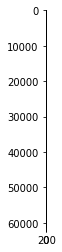

In [77]:
dataiter = iter(train_loader)
labels,images = dataiter.next()

images_grid = images.view(-1,1,28,28)
img_grid = torchvision.utils.make_grid(images_grid,nrow=8)
plt.imshow(img_grid[1,:,:], cmap='gray')

classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle_boot']

In [51]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 784)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()
#         self.softmax = nn.Softmax()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
#         x = self.softmax(x)
        return x


net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())
net

Net(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)

In [52]:
#  tensorboard --logdir=runs

writer = SummaryWriter('runs/fashion_mnist_experiment_2')

iterations = 200


for epoch in range(iterations):
    running_loss = 0.0
    for i,data in enumerate(train_loader):

        labels, images = data
        outputs, inputs = Variable(labels).to(device), Variable(images).to(device)
#         one_hots = torch.Tensor([convert_to_one_hot(int(i),10) for i in outputs]).view(1,-1)
        
        y_pred = net.forward(inputs.float().to(device))

        loss = criterion(y_pred, outputs.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if epoch % 2 == 0:
        print('epochs: {}, loss: {}'.format(epoch, running_loss))
        writer.add_scalar('training loss',running_loss, epoch)
        
    if epoch % 100 == 0:
        PATH = './saved_model.pth'
        torch.save(net.state_dict(), PATH)
        print("Model Saved! at epoch no.: {}".format(epoch))

writer.close()

epochs: 0, loss: 8.96084713935852
Model Saved! at epoch no.: 0
epochs: 2, loss: 6.916322946548462
epochs: 4, loss: 4.693787932395935
epochs: 6, loss: 3.521826446056366
epochs: 8, loss: 2.981937825679779
epochs: 10, loss: 2.647408604621887
epochs: 12, loss: 2.420339584350586
epochs: 14, loss: 2.2618632316589355
epochs: 16, loss: 2.1443451046943665
epochs: 18, loss: 2.061894655227661
epochs: 20, loss: 1.9923701882362366
epochs: 22, loss: 1.9278117418289185
epochs: 24, loss: 1.8840370774269104
epochs: 26, loss: 1.837831974029541
epochs: 28, loss: 1.800920158624649
epochs: 30, loss: 1.7708762884140015
epochs: 32, loss: 1.7428730428218842
epochs: 34, loss: 1.7118335664272308
epochs: 36, loss: 1.6837035417556763
epochs: 38, loss: 1.6577234268188477
epochs: 40, loss: 1.6393077075481415
epochs: 42, loss: 1.620559811592102
epochs: 44, loss: 1.6065105497837067
epochs: 46, loss: 1.5885439813137054
epochs: 48, loss: 1.584505558013916
epochs: 50, loss: 1.5598860085010529
epochs: 52, loss: 1.5392374

GroundTruth:  Sandal T-shirt Shirt Shirt Shirt  Coat T-shirt Ankle_boot


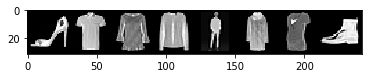

In [84]:
net = Net()
net.load_state_dict(torch.load(PATH))

dataiter = iter(test_loader)
labels ,images= dataiter.next()

images_grid = images.view(-1,1,28,28)
img_grid = torchvision.utils.make_grid(images_grid,nrow=8)
plt.imshow(img_grid[1,:,:], cmap='gray')
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [85]:
outputs = net(images.float())
print(outputs.shape)
_, predicted = torch.max(outputs, 1)

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(8)))

torch.Size([8, 10])
GroundTruth:  Sandal T-shirt Shirt Shirt Shirt  Coat T-shirt Ankle_boot
Predicted:  Sandal T-shirt Shirt Pullover Trouser  Coat T-shirt Ankle_boot
